In [ ]:
!python --version
!pip --version

Python 3.7.10
pip 19.3.1 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


In [ ]:
# import os 

# imgs = os.listdir('dataset/IMG')
# for img in imgs:
#   os.remove(f'dataset/IMG/{img}')

# os.removedirs('dataset/IMG')
# csvs = os.listdir('dataset')

# for csv in csvs:
#   os.remove(f'dataset/{csv}')
# os.removedirs('dataset')

# os.remove('adc.json')

In [ ]:
!pip install -U -q PyDrive
import os
if not os.path.isdir('dataset'):
  # file_id = "19_DmedNrScdgd1LLRvKXuLImIqW5pJK9"
  file_id = "1OwRIz-tadaQ90e8VlzmOVMJYmX2RdL7W"
 
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
 
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
 
  from google.colab import auth
  auth.authenticate_user()
 
  from googleapiclient.discovery import build
  drive_service = build('drive', 'v3')
 
  import io
  from googleapiclient.http import MediaIoBaseDownload
 
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()
 
  fileId = drive.CreateFile({'id': file_id })
  print(fileId['title'])  
  fileId.GetContentFile(fileId['title'])
  !unzip {fileId['title']}
 
else:
  print('Colab contents already exist.')

Streaming output truncated to the last 5000 lines.
  inflating: dataset/IMG/right_2019_04_02_19_32_15_010.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_081.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_150.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_224.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_291.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_358.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_426.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_497.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_571.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_639.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_713.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_789.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_862.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_15_933.jpg  
  inflating: dataset/IMG/right_2019_04_02_19_32_16_007.jpg  
  inflating: dataset/IMG/right_201

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam, SGD

from keras.callbacks import ModelCheckpoint

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

In [ ]:
def add_random_shadow(img, w_low=0.6, w_high=0.85):
    """
    Overlays supplied image with a random shadow polygon
    The weight range (i.e. darkness) of the shadow can be configured via the interval [w_low, w_high)
    """
    
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)
    
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (0, 0, 0))
    #masked_image = cv2.bitwise_and(img, mask)
    
    return cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

In [ ]:
def random_erasing(image):
    '''
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing values
    '''

    sl = 0.01
    sh = 0.2
    r1 = 0.3
    mean=[0.4914, 0.4822, 0.4465]
    img = np.copy(image)

    for _ in range(100):
        area = img.shape[0] * img.shape[1]

        target_area = random.uniform(sl, sh) * area
        aspect_ratio = random.uniform(r1, 1/r1)

        h = int(round(math.sqrt(target_area * aspect_ratio)))
        w = int(round(math.sqrt(target_area / aspect_ratio)))
        
        if w < img.shape[1] and h < img.shape[0]:
            x1 = random.randint(0, img.shape[0] - h)
            y1 = random.randint(0, img.shape[1] - w)
            if img.shape[2] == 3:
                img[x1:x1+h, y1:y1+w, 0] = mean[0]
                img[x1:x1+h, y1:y1+w, 1] = mean[1]
                img[x1:x1+h, y1:y1+w, 2] = mean[2]
            else:
                img[x1:x1+h, y1:y1+w, 0] = 255
            return img

    return img

In [ ]:
def flip_image_h(image, s_angle):
    '''
    img: cv2 Image (numpy array),
    s_angle: steering angle (float)
    
    returns: flipped image and flipped steering angle
    '''

    img = np.copy(image)
    return np.flip(img, 1), (s_angle * -1) * 1.2


In [ ]:
def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

In [ ]:
def change_brightness(img):
    '''
    img: opencv image (numpy array)

    returns: a new opencv image (numpy array) with manipulated brightness level.
    '''

    image = np.copy(img)
    new_image = np.zeros(image.shape, image.dtype)
    alpha = random.uniform(0.4, 1.35)
    beta = random.randint(1,50)
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    return new_image

In [ ]:
def gaussian_noise(img):
  '''
  img: opencv image (numpy array)

  returns: a new opencv image (numpy array) with manipulated noise level.
  '''

  mean = 0
  var = random.randint(50, 200)
  sigma = var ** 0.5
  gaussian = np.random.normal(mean, sigma, (img.shape[0],img.shape[1]))

  noisy_image = np.zeros(img.shape, np.float32)

  if len(img.shape) == 2:
      noisy_image = img + gaussian
  else:
      noisy_image[:, :, 0] = img[:, :, 0] + gaussian
      noisy_image[:, :, 1] = img[:, :, 1] + gaussian
      noisy_image[:, :, 2] = img[:, :, 2] + gaussian

  cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
  noisy_image = noisy_image.astype(np.uint8)
  
  return noisy_image

In [ ]:
def get_path(p):
  p_l = p.split('\\')
  p_l[-3] = 'dataset'
  return "/".join([p_l[-3], p_l[-2], p_l[-1]])

In [ ]:
def convert_img(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
  img = img[60:-25, :, :]
  img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
  return img

In [ ]:
def batch_data_generator(df):
  """
  Generate batch of data with changed values.
  """
  img_data = []
  sa_data = []
  for _, row in df.iterrows():
    steering_angle = row['STEERING_ANGLE']
    center = cv2.imread(get_path(row['CENTER']))
    left = cv2.imread(get_path(row['LEFT']))
    right = cv2.imread(get_path(row['RIGHT']))
    changed = False
    # [ gaussian_noise(img), change_brightness(img), flip_image_h(image, s_angle), random_erasing(image), add_random_shadow(img)]
    i = 0
    j = 0
    for Img in [center, left, right]:
      if i == 1:
        steering_angle = steering_angle + 0.2
      
      elif i == 2:
        steering_angle = steering_angle - 0.2

      i = (i + 1) % 3

      if changed:
        img_data.append(convert_img(Img))
        sa_data.append(steering_angle)

      changed = False
      if j == 0:
        Img = add_random_shadow(Img)
        changed = True

      # if j == 1:
      #   Img, steering_angle = random_translate(Img, steering_angle, 100, 10)
      #   changed = True
        
      if j == 1:
        Img, steering_angle = flip_image_h(Img, steering_angle)
        changed = True

      if j == 2:
        Img = change_brightness(Img)
        changed = True

      if j == 3:
        Img = gaussian_noise(Img)
        changed = True
      
      j = (j + 1) % 4

  return img_data, sa_data

CENTER            dataset\IMG\center_2019_04_02_19_25_33_671.jpg
LEFT                dataset\IMG\left_2019_04_02_19_25_33_671.jpg
RIGHT              dataset\IMG\right_2019_04_02_19_25_33_671.jpg
STEERING_ANGLE                                                 0
SPEED                                                          0
THROTTLE                                                       0
BRAKES                                                  1.06e-05
Name: 0, dtype: object
(66, 200, 3)


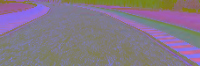

In [ ]:
names=['CENTER','LEFT','RIGHT','STEERING_ANGLE','SPEED','THROTTLE','BRAKES']
# data_csv1 = pd.read_csv("dataset/edge_oriented_log.csv", names=names)
# data_csv2 = pd.read_csv("dataset/huge_log.csv", names=names)
# data_csv3 = pd.read_csv("dataset/standard_log.csv", names=names)
# data_csv4 = pd.read_csv("dataset/track2.csv", names=names)
# data_csv5 = pd.read_csv("dataset/driving_log.csv", names=names)
data_csv1 = pd.read_csv("dataset/driving_log.csv", names=names)

data_csvs = [
data_csv1,
# data_csv2,
# data_csv3,
# data_csv4,
# data_csv5
]

for _, row in data_csv1.iterrows():
  img = cv2.imread(get_path(str(row['CENTER'])))
  print(row)
  break

img = convert_img(img)
print(img.shape)
cv2_imshow(img)

In [ ]:
for data in data_csvs:
  df_zeros = data[data['STEERING_ANGLE'] == 0]
  print("\nNo. of zero steering angle:", len(df_zeros), "\nTotal records", len(data))


No. of zero steering angle: 18997 
Total records 32443


In [ ]:
data_csv = pd.concat(data_csvs)
total_images = len(data_csv) * 3
(total_images).__str__() + " total images."

'97329 total images.'

In [ ]:
print(len(data_csv[data_csv['STEERING_ANGLE'] == 0.0].sample(frac=1, replace = False, random_state = 1))* 3)
print(len(data_csv[data_csv['STEERING_ANGLE'] != 0.0].sample(frac=1, replace = False, random_state = 1))* 3)

56991
40338


In [ ]:
def increase_images(img, s_angle):
  choice = random.randint(0,3)
  # [ gaussian_noise(img), change_brightness(img), flip_image_h(image, s_angle), random_erasing(image), add_random_shadow(img)]
  if choice == 0:
    return gaussian_noise(img), s_angle
  if choice == 1:
    return change_brightness(img), s_angle
  if choice == 2:
    new_img, new_angle = flip_image_h(img, s_angle)
    return new_img, new_angle
  if choice == 3:
    return add_random_shadow(img), s_angle

In [ ]:
training_data = []
# data_csv = data_csv.sample(frac=1).reset_index(drop=True)
data_csv = data_csv.drop(data_csv[data_csv['STEERING_ANGLE'] == 0.0].sample(frac=.8).index)

for _, row in data_csv.iterrows():
  training_data.append([
      convert_img(cv2.imread(get_path(row['CENTER']))),
      [float (row['STEERING_ANGLE']), float (row['SPEED'])]
    ])
  training_data.append([
      convert_img(cv2.imread(get_path(row['LEFT']))),
      [float (row['STEERING_ANGLE']) + 0.2, float (row['SPEED'])]
    ])
  training_data.append([
      convert_img(cv2.imread(get_path(row['RIGHT']))),
      [float (row['STEERING_ANGLE']) - 0.2, float (row['SPEED'])]
    ])
  

X = []
y = []

for img_arr, val in training_data:
  X.append(img_arr)
  y.append(val)

del training_data

In [ ]:
# d = {}
# for ele in y:
#   if ele in d:
#     d[ele] += 1
#   else:
#     d[ele] = 1

# for key, val in d.items():
#   print(f"{'{:.2}'.format(key)} : {val}")

In [ ]:
# d=0
zipped = list(zip(X, y))
zipped = zipped.copy()
for img, arr in zipped:
  angle, speed = arr 
  if (angle == 0.0 or angle != 0.2 or angle != -0.2) and random.uniform(0, 1) > 0.7 :
    new_img, new_angle = increase_images(img, angle)
    X.append(new_img)
    y.append([new_angle, speed])
  elif angle != 0.0 and angle != 0.2 and angle != -0.2 and random.uniform(0, 1) > 0.7:
    # for _ in range(10):
    new_img, new_angle = increase_images(img, angle)
    X.append(new_img)
    y.append([new_angle, speed])

del zipped

In [ ]:
# d = {}
# for ele in y:
#   if ele in d:
#     d[ele] += 1
#   else:
#     d[ele] = 1

X = np.asarray(X)
y = np.asarray(y)
# for key, val in d.items():
#   print(f"{'{:.2}'.format(key)} : {val}")
# del d
print("\n\n{}".format(X.shape), y.shape)



(75380, 66, 200, 3) (75380, 2)


In [ ]:
model = Sequential()

model.add(layers.Lambda(lambda x: x/127.5-1.0, input_shape=X.shape[1:]))

model.add(layers.Conv2D(24, (5, 5), strides = (2, 2), activation='elu'))
model.add(layers.Conv2D(36, (5, 5), strides = (2, 2), activation='elu'))
model.add(layers.Conv2D(48, (5, 5), strides = (2, 2), activation='elu'))
model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.Conv2D(64, (3, 3), activation='elu'))

model.add(layers.Dropout(rate=0.3))

model.add(layers.Flatten())

model.add(layers.Dense(100, activation='elu'))

model.add(layers.Dense(50, activation='elu'))

model.add(layers.Dense(10, activation='elu'))

model.add(layers.Dense(2))
model.summary()

checkpoint = ModelCheckpoint('model.h5',
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='auto')

model.compile(
    loss='MSE', 
    optimizer=Adam(learning_rate=0.0008),
    metrics=['accuracy'],
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0

In [ ]:
# model = tf.keras.models.load_model('my_model_yuv1.h5')

In [ ]:
history = model.fit(
    X,y,
    batch_size=100,
    epochs=50, 
    callbacks=[checkpoint],
    validation_split=0.2,
    shuffle=1,
    verbose=1,
)

Epoch 1/50
604/604 [==============================] - 352s 581ms/step - loss: 0.1175 - accuracy: 0.7527 - val_loss: 0.1520 - val_accuracy: 0.7756

Epoch 00001: val_loss improved from inf to 0.15202, saving model to model.h5
Epoch 2/50
604/604 [==============================] - 354s 587ms/step - loss: 0.1008 - accuracy: 0.7768 - val_loss: 0.1401 - val_accuracy: 0.7936

Epoch 00002: val_loss improved from 0.15202 to 0.14012, saving model to model.h5
Epoch 3/50
604/604 [==============================] - 351s 582ms/step - loss: 0.0940 - accuracy: 0.7854 - val_loss: 0.1330 - val_accuracy: 0.8088

Epoch 00003: val_loss improved from 0.14012 to 0.13304, saving model to model.h5
Epoch 4/50
604/604 [==============================] - 351s 581ms/step - loss: 0.0894 - accuracy: 0.7915 - val_loss: 0.1281 - val_accuracy: 0.8089

Epoch 00004: val_loss improved from 0.13304 to 0.12805, saving model to model.h5
Epoch 5/50
604/604 [==============================] - 351s 580ms/step - loss: 0.0848 - accur

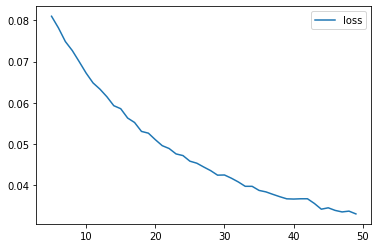

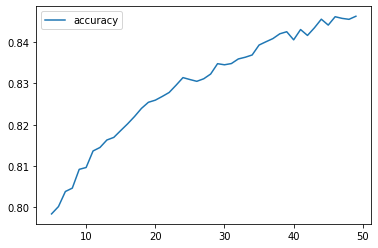

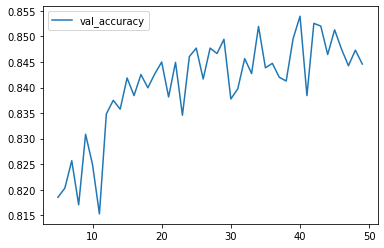

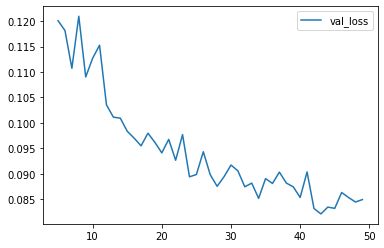

In [ ]:
# del X
# del y

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss']].plot();
history_df.loc[5:, ['accuracy']].plot();
history_df.loc[5:, ['val_accuracy']].plot();
history_df.loc[5:, ['val_loss']].plot();

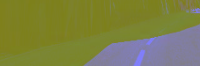

Predicted value:  [0.53439164 0.04193377] 
Actual Value:  0.6500001 0.0


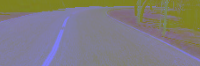

Predicted value:  [-1.0485855   0.09302401] 
Actual Value:  -1.0 0.02428012


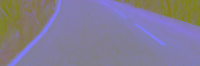

Predicted value:  [-0.38298815  0.12809944] 
Actual Value:  -0.25 0.03113687


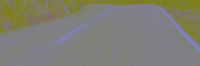

Predicted value:  [0.49565    0.41570488] 
Actual Value:  0.5500001 0.4977438


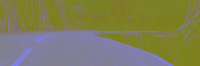

Predicted value:  [-0.8858328   0.79214305] 
Actual Value:  -0.8000001 0.60824


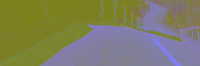

Predicted value:  [0.36566126 0.17218503] 
Actual Value:  0.35 0.08139415


In [ ]:
df = data_csv[data_csv['STEERING_ANGLE'] != 0].sample(n=6)

for _, row in df.iterrows():
  try:
    img = cv2.imread(get_path(row['CENTER']))
    img = convert_img(img)
    cv2_imshow(img)
    print("Predicted value: ", model.predict(np.asarray([img]))[0], "\nActual Value: ", row['STEERING_ANGLE'], row['SPEED'])
  except Exception as e:
    print(e)
model.save('my_model.h5')

In [ ]:
test_images = []
test_labels = []
for _, row in df.iterrows():
  img = cv2.imread(get_path(row['CENTER']))
  img = convert_img(img)

  test_images.append(img)
  test_labels.append(row['STEERING_ANGLE'])

loss, acc = model.evaluate(np.array(test_images), np.array(test_labels), verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

1/1 - 0s - loss: 0.3613 - accuracy: 0.5000
Restored model, accuracy: 50.00%
